# Step 1: Understand the Dataset

In [1]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np


Set dataset path

In [3]:
dataset_path = '/content/drive/MyDrive/Classroom/classification_dataset' # Change path if needed
splits = ['train', 'valid', 'test']

Inspect folder structure & count images per class

In [4]:
print("=== Dataset Folder Structure & Image Count ===")
class_counts = {}

for split in splits:
    print(f"\n--- {split.upper()} ---")
    split_path = os.path.join(dataset_path, split)

    if not os.path.exists(split_path):
        print(f"{split_path} not found!")
        continue

    classes = os.listdir(split_path)
    for cls in classes:
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            num_images = len(os.listdir(cls_path))
            class_counts[f"{split}/{cls}"] = num_images
            print(f"Class '{cls}': {num_images} images")

=== Dataset Folder Structure & Image Count ===

--- TRAIN ---
Class 'drone': 1248 images
Class 'bird': 1414 images

--- VALID ---
Class 'bird': 217 images
Class 'drone': 225 images

--- TEST ---
Class 'bird': 121 images
Class 'drone': 94 images


Identify class imbalance


=== Class Imbalance Check ===
train/drone: 1248 images
train/bird: 1414 images
valid/bird: 217 images
valid/drone: 225 images
test/bird: 121 images
test/drone: 94 images


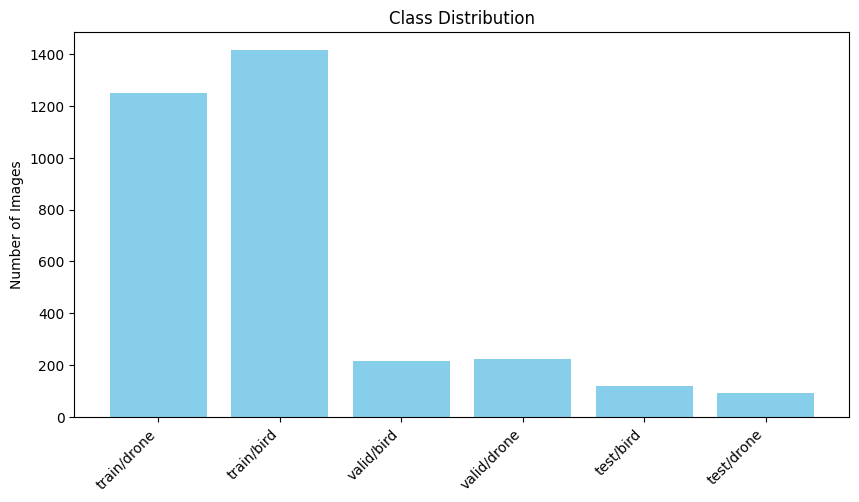

In [5]:
print("\n=== Class Imbalance Check ===")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

# Optional: plot a bar chart for class distribution
plt.figure(figsize=(10,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.show()

 Visualize sample images


=== Sample Images ===


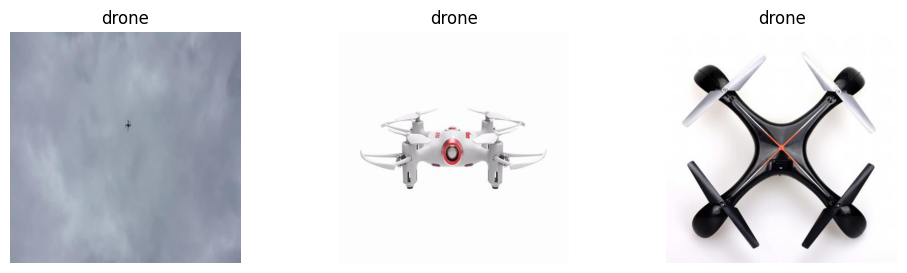

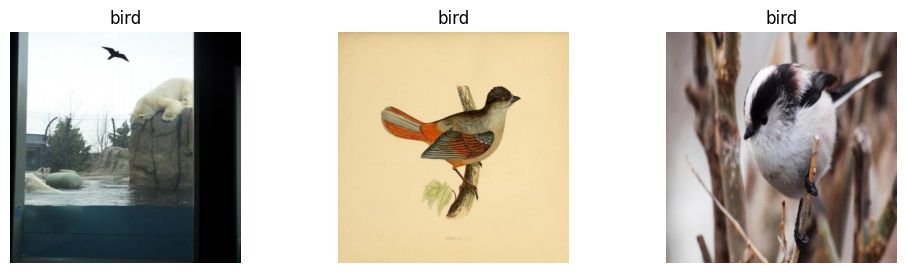

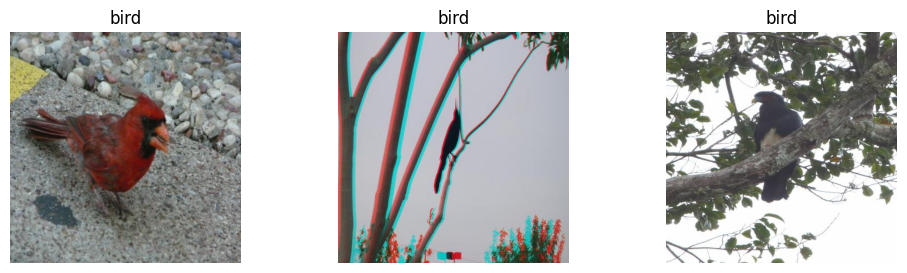

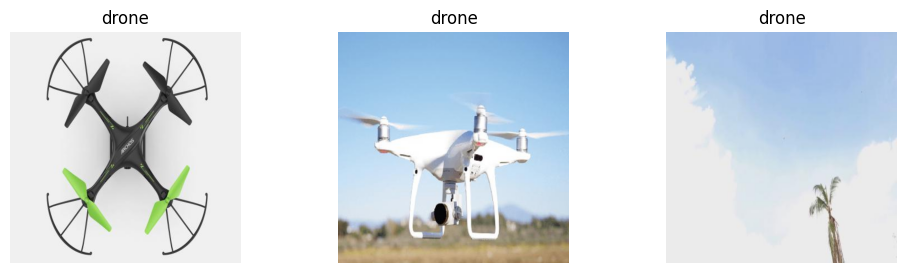

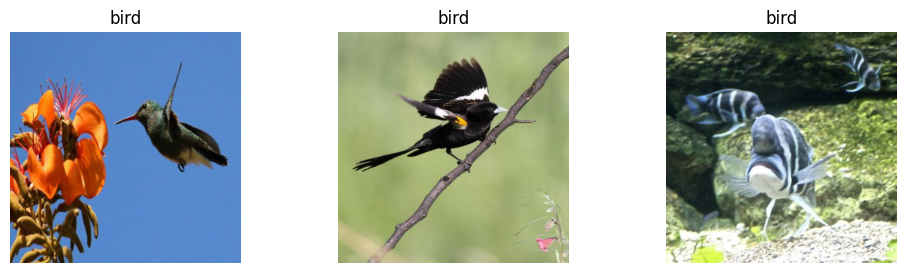

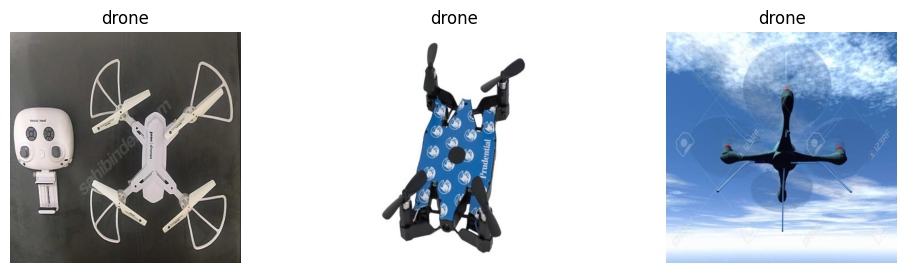

In [6]:
print("\n=== Sample Images ===")
num_samples = 3  # number of images per class to display

for split in splits:
    split_path = os.path.join(dataset_path, split)
    if not os.path.exists(split_path):
        continue
    classes = os.listdir(split_path)
    for cls in classes:
        cls_path = os.path.join(split_path, cls)
        images = os.listdir(cls_path)
        sample_images = random.sample(images, min(num_samples, len(images)))

        plt.figure(figsize=(12,3))
        for i, img_name in enumerate(sample_images):
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path)
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img)
            plt.title(f"{cls}")
            plt.axis("off")
        plt.show()

# Step 2: Data Preprocessing

In [7]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

 Parameters


In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

Create Custom Dataset class

In [9]:
class BirdDroneDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = os.path.join(data_dir, split)
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = sorted(os.listdir(self.data_dir))

        for label, class_name in enumerate(self.classes):
            class_folder = os.path.join(self.data_dir, class_name)
            for file in os.listdir(class_folder):
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    self.images.append(os.path.join(class_folder, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label



Create Dataset and DataLoader

In [10]:
dataset_path = '/content/drive/MyDrive/Classroom/classification_dataset' # Ensure dataset_path is correct here

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = BirdDroneDataset(dataset_path, split='train', transform=transform)
valid_dataset = BirdDroneDataset(dataset_path, split='valid', transform=transform)
test_dataset = BirdDroneDataset(dataset_path, split='test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Test the DataLoader

In [11]:
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")   # [batch_size, 3, 224, 224]
print(f"Labels shape: {labels.shape}")  # [batch_size]
print(f"Classes: {train_dataset.classes}")

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Classes: ['bird', 'drone']


# Step 3: Data Augmentation

In [12]:
from torchvision import transforms

Define Data Augmentation for Training

In [13]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),        # Randomly flip image horizontally
    transforms.RandomVerticalFlip(),          # Randomly flip image vertically
    transforms.RandomRotation(30),            # Random rotation ±30 degrees
    transforms.ColorJitter(
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
    ),                                        # Random brightness, contrast, saturation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


Validation and Test transforms (no augmentation, only resize & normalize)

In [14]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


Create Datasets with Augmentation

In [15]:
train_dataset = BirdDroneDataset(dataset_path, split='train', transform=train_transform)
valid_dataset = BirdDroneDataset(dataset_path, split='valid', transform=test_transform)
test_dataset = BirdDroneDataset(dataset_path, split='test', transform=test_transform)

DataLoader

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Visualize Augmented Images

In [17]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(train_loader))

Unnormalize for display

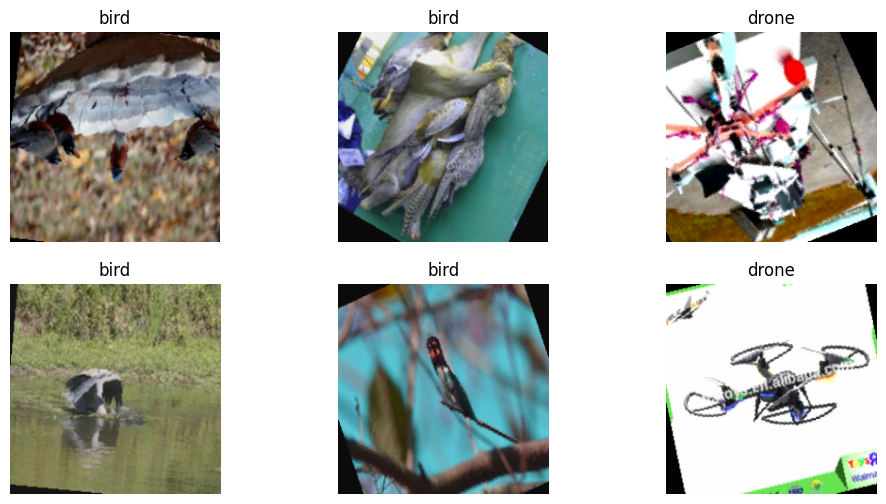

In [18]:
images = images / 2 + 0.5
images = images.numpy()

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    plt.title(train_dataset.classes[labels[i]])
    plt.axis('off')
plt.show()

 # Step 4: Model Building (Classification)

In [19]:
import torch
import torch.nn as nn
from torchvision import models

Check for GPU

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


 4-A. Custom CNN Model

In [22]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128*28*28, 256),  # 224/2/2/2 = 28
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

custom_model = CustomCNN(num_classes=len(train_dataset.classes)).to(device)
print("Custom CNN:\n", custom_model)

Custom CNN:
 CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
   

4-B. Transfer Learning: ResNet50

In [23]:
resnet_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in resnet_model.parameters():
    param.requires_grad = False
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, len(train_dataset.classes))
resnet_model = resnet_model.to(device)
print("ResNet50:\n", resnet_model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


ResNet50:
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), 

4-C. Transfer Learning: MobileNetV2

In [24]:
mobilenet_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
for param in mobilenet_model.parameters():
    param.requires_grad = False
num_features = mobilenet_model.classifier[1].in_features
mobilenet_model.classifier[1] = nn.Linear(num_features, len(train_dataset.classes))
mobilenet_model = mobilenet_model.to(device)
print("MobileNetV2:\n", mobilenet_model)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 69.5MB/s]

MobileNetV2:
 MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchN

4-D. Transfer Learning: EfficientNetB0

In [25]:
efficientnet_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
for param in efficientnet_model.parameters():
    param.requires_grad = False
num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(num_features, len(train_dataset.classes))
efficientnet_model = efficientnet_model.to(device)
print("EfficientNetB0:\n", efficientnet_model)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 163MB/s]

EfficientNetB0:
 EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): 

# Step 5: Model Training

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import copy
import os

Training Parameters

In [27]:
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 1e-4
PATIENCE = 3  # EarlyStopping patience

Loss Function

In [28]:
criterion = nn.CrossEntropyLoss()

Optimizer

In [29]:
def get_optimizer(model):
    return optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

Training Function

In [30]:
def train_model(model, train_loader, valid_loader, model_name="model"):
    optimizer = get_optimizer(model)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience_counter = 0

    train_losses, valid_losses = [], []

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        # --- Training ---
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_precision = precision_score(all_labels, all_preds, average='macro')
        epoch_recall = recall_score(all_labels, all_preds, average='macro')
        epoch_f1 = f1_score(all_labels, all_preds, average='macro')
        train_losses.append(epoch_loss)
        print(f"Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | Prec: {epoch_precision:.4f} | Rec: {epoch_recall:.4f} | F1: {epoch_f1:.4f}")

        # --- Validation ---
        model.eval()
        running_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = running_loss / len(valid_loader.dataset)
        val_acc = accuracy_score(all_labels, all_preds)
        val_precision = precision_score(all_labels, all_preds, average='macro')
        val_recall = recall_score(all_labels, all_preds, average='macro')
        val_f1 = f1_score(all_labels, all_preds, average='macro')
        valid_losses.append(val_loss)
        print(f"Valid Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Prec: {val_precision:.4f} | Rec: {val_recall:.4f} | F1: {val_f1:.4f}")

        # EarlyStopping + ModelCheckpoint
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
            torch.save(model.state_dict(), f"{model_name}_best.pth")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered!")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses

 Train All Models

1️⃣ Custom CNN

In [31]:
trained_custom_model, train_losses_custom, valid_losses_custom = train_model(
    custom_model, train_loader, valid_loader, model_name="custom_cnn"
)


Epoch 1/15
Train Loss: 0.7415 | Acc: 0.6465 | Prec: 0.6450 | Rec: 0.6427 | F1: 0.6429
Valid Loss: 0.5627 | Acc: 0.6787 | Prec: 0.6787 | Rec: 0.6787 | F1: 0.6787

Epoch 2/15
Train Loss: 0.5735 | Acc: 0.7029 | Prec: 0.7051 | Rec: 0.6972 | F1: 0.6974
Valid Loss: 0.4875 | Acc: 0.7692 | Prec: 0.7737 | Rec: 0.7680 | F1: 0.7677

Epoch 3/15
Train Loss: 0.5355 | Acc: 0.7261 | Prec: 0.7264 | Rec: 0.7225 | F1: 0.7232
Valid Loss: 0.5185 | Acc: 0.7353 | Prec: 0.7507 | Rec: 0.7330 | F1: 0.7298

Epoch 4/15
Train Loss: 0.5187 | Acc: 0.7400 | Prec: 0.7423 | Rec: 0.7353 | F1: 0.7361
Valid Loss: 0.4835 | Acc: 0.7692 | Prec: 0.7828 | Rec: 0.7672 | F1: 0.7655

Epoch 5/15
Train Loss: 0.4956 | Acc: 0.7569 | Prec: 0.7576 | Rec: 0.7536 | F1: 0.7545
Valid Loss: 0.4549 | Acc: 0.7760 | Prec: 0.7803 | Rec: 0.7748 | F1: 0.7746

Epoch 6/15
Train Loss: 0.4802 | Acc: 0.7690 | Prec: 0.7683 | Rec: 0.7672 | F1: 0.7676
Valid Loss: 0.4532 | Acc: 0.8009 | Prec: 0.8010 | Rec: 0.8007 | F1: 0.8008

Epoch 7/15
Train Loss: 0.47

2️⃣ ResNet50

In [32]:
trained_resnet, train_losses_resnet, valid_losses_resnet = train_model(
    resnet_model, train_loader, valid_loader, model_name="resnet50"
)


Epoch 1/15
Train Loss: 0.5668 | Acc: 0.8009 | Prec: 0.8043 | Rec: 0.8042 | F1: 0.8009
Valid Loss: 0.4280 | Acc: 0.9095 | Prec: 0.9127 | Rec: 0.9087 | F1: 0.9092

Epoch 2/15
Train Loss: 0.4040 | Acc: 0.9038 | Prec: 0.9040 | Rec: 0.9028 | F1: 0.9033
Valid Loss: 0.3078 | Acc: 0.9480 | Prec: 0.9490 | Rec: 0.9476 | F1: 0.9479

Epoch 3/15
Train Loss: 0.3261 | Acc: 0.9128 | Prec: 0.9132 | Rec: 0.9118 | F1: 0.9124
Valid Loss: 0.2481 | Acc: 0.9502 | Prec: 0.9515 | Rec: 0.9498 | F1: 0.9501

Epoch 4/15
Train Loss: 0.2840 | Acc: 0.9196 | Prec: 0.9197 | Rec: 0.9188 | F1: 0.9192
Valid Loss: 0.2198 | Acc: 0.9615 | Prec: 0.9622 | Rec: 0.9612 | F1: 0.9615

Epoch 5/15
Train Loss: 0.2452 | Acc: 0.9279 | Prec: 0.9278 | Rec: 0.9273 | F1: 0.9275
Valid Loss: 0.1827 | Acc: 0.9570 | Prec: 0.9581 | Rec: 0.9566 | F1: 0.9569

Epoch 6/15
Train Loss: 0.2254 | Acc: 0.9298 | Prec: 0.9300 | Rec: 0.9289 | F1: 0.9294
Valid Loss: 0.1673 | Acc: 0.9638 | Prec: 0.9639 | Rec: 0.9637 | F1: 0.9638

Epoch 7/15
Train Loss: 0.20

3️⃣ MobileNetV2

In [33]:
trained_mobilenet, train_losses_mobilenet, valid_losses_mobilenet = train_model(
    mobilenet_model, train_loader, valid_loader, model_name="mobilenetv2"
)


Epoch 1/15
Train Loss: 0.6034 | Acc: 0.7352 | Prec: 0.7488 | Rec: 0.7265 | F1: 0.7259
Valid Loss: 0.5296 | Acc: 0.9050 | Prec: 0.9062 | Rec: 0.9055 | F1: 0.9050

Epoch 2/15
Train Loss: 0.4824 | Acc: 0.8599 | Prec: 0.8623 | Rec: 0.8571 | F1: 0.8585
Valid Loss: 0.4248 | Acc: 0.9367 | Prec: 0.9366 | Rec: 0.9367 | F1: 0.9366

Epoch 3/15
Train Loss: 0.4108 | Acc: 0.8745 | Prec: 0.8752 | Rec: 0.8729 | F1: 0.8737
Valid Loss: 0.3603 | Acc: 0.9367 | Prec: 0.9369 | Rec: 0.9365 | F1: 0.9366

Epoch 4/15
Train Loss: 0.3649 | Acc: 0.8896 | Prec: 0.8896 | Rec: 0.8886 | F1: 0.8890
Valid Loss: 0.3124 | Acc: 0.9412 | Prec: 0.9414 | Rec: 0.9410 | F1: 0.9411

Epoch 5/15
Train Loss: 0.3349 | Acc: 0.8956 | Prec: 0.8961 | Rec: 0.8942 | F1: 0.8949
Valid Loss: 0.2810 | Acc: 0.9525 | Prec: 0.9529 | Rec: 0.9523 | F1: 0.9524

Epoch 6/15
Train Loss: 0.3124 | Acc: 0.9023 | Prec: 0.9032 | Rec: 0.9008 | F1: 0.9017
Valid Loss: 0.2584 | Acc: 0.9480 | Prec: 0.9486 | Rec: 0.9477 | F1: 0.9479

Epoch 7/15
Train Loss: 0.28

4️⃣ EfficientNetB0

In [34]:
trained_efficientnet, train_losses_eff, valid_losses_eff = train_model(
    efficientnet_model, train_loader, valid_loader, model_name="efficientnetb0"
)


Epoch 1/15
Train Loss: 0.6189 | Acc: 0.7021 | Prec: 0.7018 | Rec: 0.7026 | F1: 0.7017
Valid Loss: 0.5022 | Acc: 0.8846 | Prec: 0.8848 | Rec: 0.8849 | F1: 0.8846

Epoch 2/15
Train Loss: 0.4983 | Acc: 0.8385 | Prec: 0.8402 | Rec: 0.8357 | F1: 0.8370
Valid Loss: 0.4138 | Acc: 0.9253 | Prec: 0.9254 | Rec: 0.9253 | F1: 0.9253

Epoch 3/15
Train Loss: 0.4217 | Acc: 0.8738 | Prec: 0.8776 | Rec: 0.8706 | F1: 0.8723
Valid Loss: 0.3569 | Acc: 0.9367 | Prec: 0.9369 | Rec: 0.9365 | F1: 0.9366

Epoch 4/15
Train Loss: 0.3811 | Acc: 0.8869 | Prec: 0.8884 | Rec: 0.8849 | F1: 0.8860
Valid Loss: 0.3230 | Acc: 0.9412 | Prec: 0.9411 | Rec: 0.9412 | F1: 0.9412

Epoch 5/15
Train Loss: 0.3381 | Acc: 0.9001 | Prec: 0.9019 | Rec: 0.8980 | F1: 0.8993
Valid Loss: 0.2897 | Acc: 0.9434 | Prec: 0.9435 | Rec: 0.9436 | F1: 0.9434

Epoch 6/15
Train Loss: 0.3209 | Acc: 0.9035 | Prec: 0.9041 | Rec: 0.9021 | F1: 0.9029
Valid Loss: 0.2729 | Acc: 0.9525 | Prec: 0.9525 | Rec: 0.9526 | F1: 0.9525

Epoch 7/15
Train Loss: 0.29

# Step 6: Model Evaluation

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

Function to Evaluate Model

In [51]:
def evaluate_model(model, data_loader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Accuracy, Precision, Recall, F1
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")

    return cm, acc

Example: Evaluate Custom CNN

Confusion Matrix:
[[163  54]
 [ 30 195]]


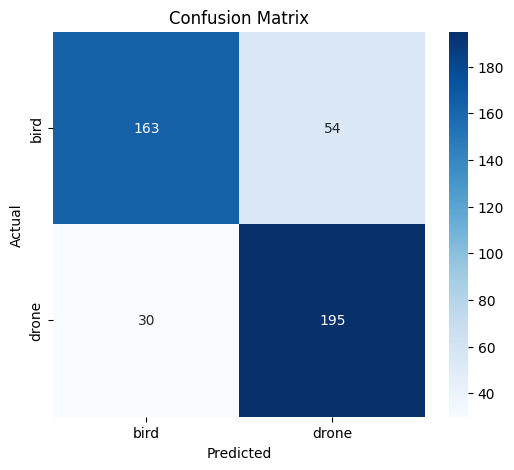


Classification Report:
              precision    recall  f1-score   support

        bird       0.84      0.75      0.80       217
       drone       0.78      0.87      0.82       225

    accuracy                           0.81       442
   macro avg       0.81      0.81      0.81       442
weighted avg       0.81      0.81      0.81       442

Accuracy: 0.8100
Precision: 0.8138
Recall: 0.8089
F1-score: 0.8090


In [55]:
class_names = train_dataset.classes  # Assuming train_dataset is defined
cm_custom, acc_custom = evaluate_model(trained_custom_model, valid_loader, class_names)

evaluate other models similarly:

Confusion Matrix:
[[210   7]
 [  2 223]]


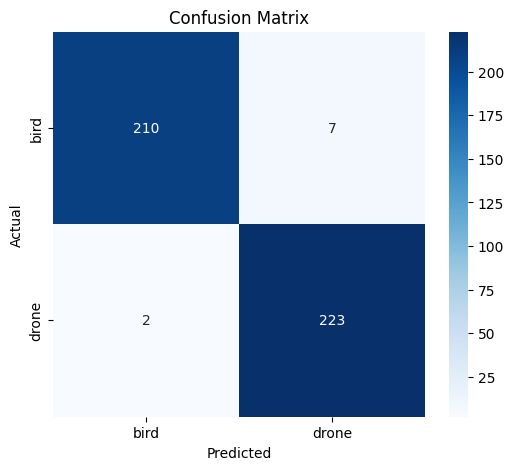


Classification Report:
              precision    recall  f1-score   support

        bird       0.99      0.97      0.98       217
       drone       0.97      0.99      0.98       225

    accuracy                           0.98       442
   macro avg       0.98      0.98      0.98       442
weighted avg       0.98      0.98      0.98       442

Accuracy: 0.9796
Precision: 0.9801
Recall: 0.9794
F1-score: 0.9796


In [57]:
cm_resnet, acc_resnet = evaluate_model(trained_resnet, valid_loader, class_names)

Confusion Matrix:
[[204  13]
 [  8 217]]


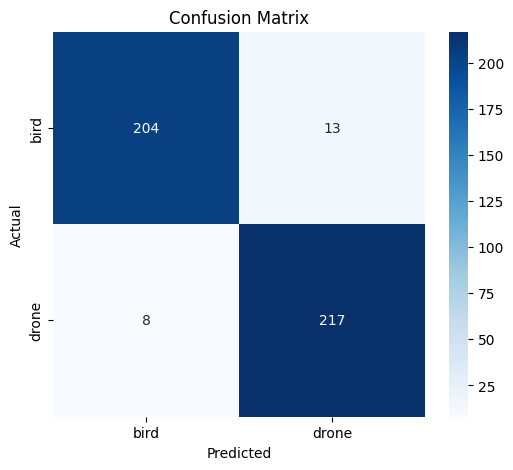


Classification Report:
              precision    recall  f1-score   support

        bird       0.96      0.94      0.95       217
       drone       0.94      0.96      0.95       225

    accuracy                           0.95       442
   macro avg       0.95      0.95      0.95       442
weighted avg       0.95      0.95      0.95       442

Accuracy: 0.9525
Precision: 0.9529
Recall: 0.9523
F1-score: 0.9524


In [58]:
cm_mobilenet, acc_mobilenet = evaluate_model(trained_mobilenet, valid_loader, class_names)

Confusion Matrix:
[[208   9]
 [ 12 213]]


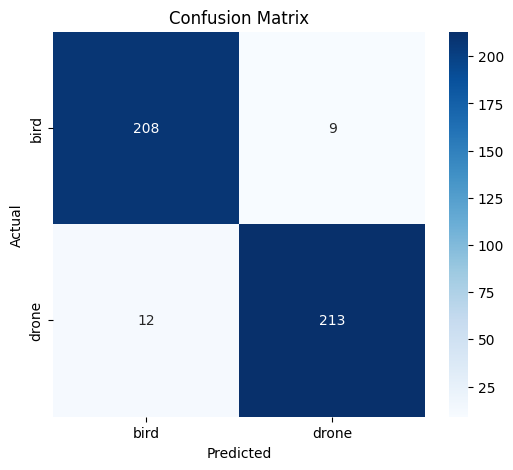


Classification Report:
              precision    recall  f1-score   support

        bird       0.95      0.96      0.95       217
       drone       0.96      0.95      0.95       225

    accuracy                           0.95       442
   macro avg       0.95      0.95      0.95       442
weighted avg       0.95      0.95      0.95       442

Accuracy: 0.9525
Precision: 0.9525
Recall: 0.9526
F1-score: 0.9525


In [59]:

cm_efficientnet, acc_efficientnet = evaluate_model(trained_efficientnet, valid_loader, class_names)

Plot Training & Validation Loss

In [60]:
def plot_loss(train_losses, valid_losses, model_name="Model"):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(valid_losses, label="Validation Loss")
    plt.title(f"{model_name} Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Example for Custom CNN

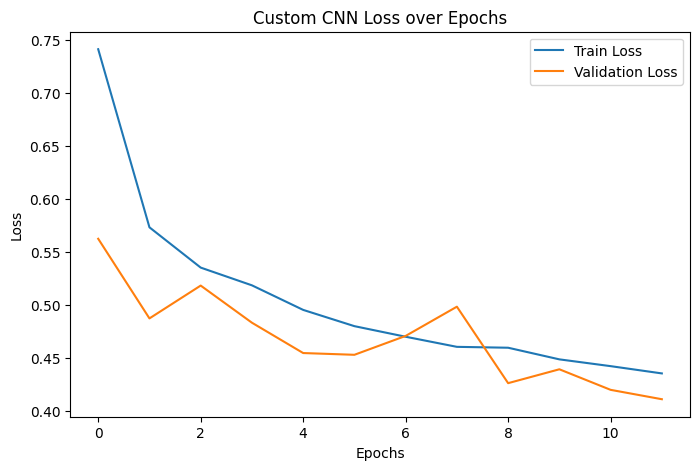

In [43]:
plot_loss(train_losses_custom, valid_losses_custom, model_name="Custom CNN")


Example for ResNet50

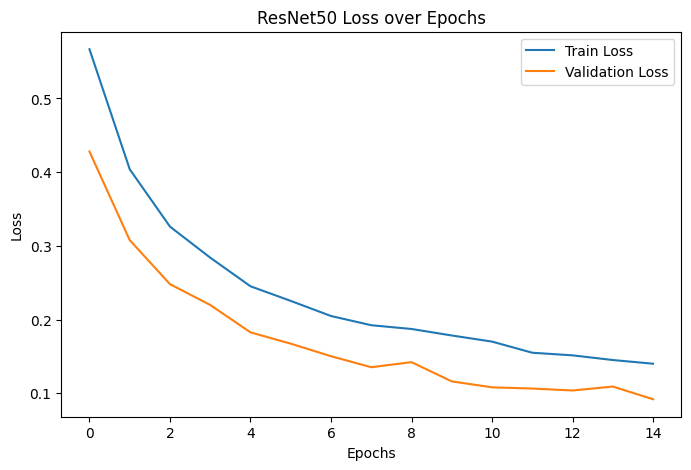

In [44]:
plot_loss(train_losses_resnet, valid_losses_resnet, model_name="ResNet50")

Example for MobileNetV2

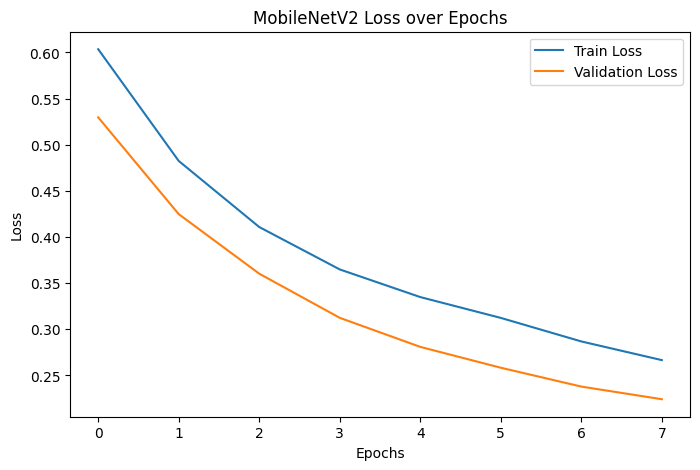

In [45]:
plot_loss(train_losses_mobilenet, valid_losses_mobilenet, model_name="MobileNetV2")

Example for EfficientNetB0

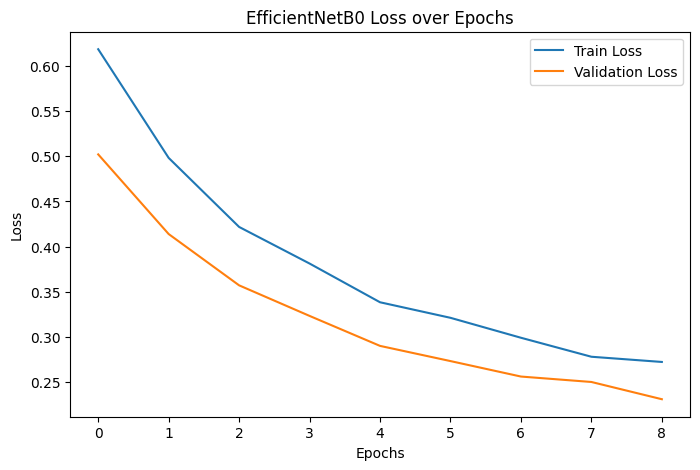

In [48]:
plot_loss(train_losses_eff, valid_losses_eff, model_name="EfficientNetB0")

# Step 7: Model Comparison

In [49]:
import pandas as pd
import torch

 acc_custom, acc_resnet, acc_mobilenet, acc_efficientnet

In [61]:
results = pd.DataFrame({
    "Model": ["Custom CNN", "ResNet50", "MobileNetV2", "EfficientNetB0"],
    "Accuracy": [
        acc_custom,
        acc_resnet,
        acc_mobilenet,
        acc_efficientnet
    ]
})

print("\n=========== MODEL COMPARISON TABLE ==========")
print(results)


=========== MODEL COMPARISON TABLE ==========
            Model  Accuracy
0      Custom CNN  0.809955
1        ResNet50  0.979638
2     MobileNetV2  0.952489
3  EfficientNetB0  0.952489


Save Best Model Automatically

In [63]:
accuracies = {
    "custom_cnn": acc_custom,
    "resnet50": acc_resnet,
    "mobilenetv2": acc_mobilenet,
    "efficientnetb0": acc_efficientnet
}

best_model_name = max(accuracies, key=accuracies.get)

print(f"\n┐ Best Model: {best_model_name} ({accuracies[best_model_name]:.4f})")


┐ Best Model: resnet50 (0.9796)


 Map model name → actual trained model object

In [65]:
model_map = {
    "custom_cnn": trained_custom_model,
    "resnet50": trained_resnet,
    "mobilenetv2": trained_mobilenet,
    "efficientnetb0": trained_efficientnet
}

best_model = model_map[best_model_name]

 Save best model

In [66]:
torch.save(best_model.state_dict(), "best_model.pth")

print("\n┈ Best model saved as: best_model.pth")
print("→ Ready to use for Streamlit deployment!")


┈ Best model saved as: best_model.pth
→ Ready to use for Streamlit deployment!


# Optional: Object Detection with YOLOv8


STEP 1 — Install YOLOv8

In [9]:
!pip install ultralytics
from ultralytics import YOLO
import os
import shutil

STEP 2 — Upload Your Dataset to Google Drive

In [10]:
original_dataset_path = "/content/drive/MyDrive/AeroVision_Dataset_for_YOLOv8_Object_Detection"
local_dataset_path = "/content/YOLO_dataset"


Copy dataset once

In [11]:
if not os.path.exists(local_dataset_path):
    print(f"Copying dataset from {original_dataset_path} to {local_dataset_path}...")
    shutil.copytree(original_dataset_path, local_dataset_path)
    print("Dataset copied successfully!")
else:
    print(f"Dataset already exists at {local_dataset_path}. Skipping copy.")

dataset_path = local_dataset_path


Copying dataset from /content/drive/MyDrive/AeroVision_Dataset_for_YOLOv8_Object_Detection to /content/YOLO_dataset...
Dataset copied successfully!


STEP 3. Create YAML

In [12]:
yaml_content = f"""
path: {dataset_path}

train: train/images
val: valid/images

names:
  0: Bird
  1: Drone
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)

print("data.yaml created!")


data.yaml created!


STEP 4 — Train YOLOv8

In [13]:
model = YOLO("yolov8n.pt")
model.train(
    data="data.yaml",
    epochs=15,
    imgsz=416,
    batch=8,
    patience=5,
    device=0,
    workers=2
)


Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretrained=True, pro

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x781636a221b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

STEP 5.Evaluate the trained model

In [14]:
metrics = model.val()
print(metrics)


Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 883.6±459.3 MB/s, size: 24.2 KB)
val: Scanning /content/YOLO_dataset/valid/labels.cache... 448 images, 6 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 448/448 719.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 28/28 7.1it/s 4.0s
                   all        448        663      0.839      0.733      0.804      0.521
                  Bird        217        414      0.794      0.586       0.68      0.397
                 Drone        225        249      0.885       0.88      0.927      0.645
Speed: 1.0ms preprocess, 2.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: u

STEP 6. Run Inference on Test or New Images

A. Inference on a single image


image 1/1 /content/YOLO_dataset/test/images/00083b384685315d_jpg.rf.abfd1b2cc8c681777bae66d5327bb9ea.jpg: 416x416 1 Bird, 9.0ms
Speed: 3.9ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)
Results saved to /content/runs/detect/predict


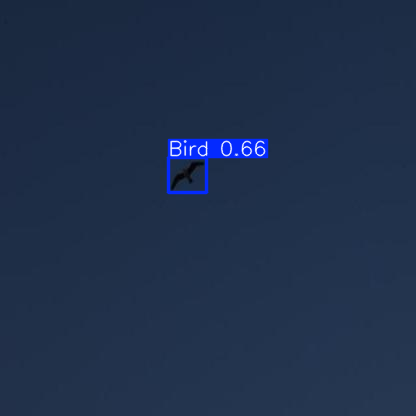

In [16]:
test_image = os.path.join(dataset_path, "test", "images", "00083b384685315d_jpg.rf.abfd1b2cc8c681777bae66d5327bb9ea.jpg")
results = model.predict(source=test_image, conf=0.25, save=True)
results[0].show()

B. Inference on a folder of images

In [17]:
test_folder = os.path.join(dataset_path, "test", "images")
results = model.predict(source=test_folder, conf=0.25, save=True)


image 1/224 /content/YOLO_dataset/test/images/00083b384685315d_jpg.rf.abfd1b2cc8c681777bae66d5327bb9ea.jpg: 416x416 1 Bird, 9.0ms
image 2/224 /content/YOLO_dataset/test/images/00188d7f40a84793_jpg.rf.7f9da2b662dc236fbdcc1f22d8e0983e.jpg: 416x416 1 Bird, 6.5ms
image 3/224 /content/YOLO_dataset/test/images/0028adf0e92c3da2_jpg.rf.48c97d30547a46e83abcbd1bf801c72f.jpg: 416x416 2 Birds, 7.3ms
image 4/224 /content/YOLO_dataset/test/images/00347cbbeed4bedb_jpg.rf.aa19c9a7a22d76f8539ca12ac7cb82d5.jpg: 416x416 2 Birds, 6.7ms
image 5/224 /content/YOLO_dataset/test/images/004cc8de466969bc_jpg.rf.ca1ffa31f30a92a3987e689583983973.jpg: 416x416 1 Bird, 9.0ms
image 6/224 /content/YOLO_dataset/test/images/006ce62a72df4dd4_jpg.rf.8f8e7b6e9a26a01be91ea1b7dc4011d2.jpg: 416x416 8 Birds, 6.9ms
image 7/224 /content/YOLO_dataset/test/images/006f6769070fc876_jpg.rf.bda2b07a999cd589936497151e0d009f.jpg: 416x416 3 Birds, 6.4ms
image 8/224 /content/YOLO_dataset/test/images/007321d46c4b8ffe_jpg.rf.bdea1bdbdba7754

C. Access bounding box info programmatically

In [18]:
for result in results:
    boxes = result.boxes.xyxy
    confidences = result.boxes.conf
    classes = result.boxes.cls
    print("Boxes:", boxes)
    print("Confidences:", confidences)
    print("Classes:", classes)

Boxes: tensor([[168.5948, 157.5875, 206.5839, 192.7024]], device='cuda:0')
Confidences: tensor([0.6620], device='cuda:0')
Classes: tensor([0.], device='cuda:0')
Boxes: tensor([[ 60.3785,  33.0586, 400.3263, 381.9999]], device='cuda:0')
Confidences: tensor([0.8882], device='cuda:0')
Classes: tensor([0.], device='cuda:0')
Boxes: tensor([[167.3309, 110.1120, 252.1519, 234.5671],
        [170.0870, 120.5593, 251.6275, 281.3309]], device='cuda:0')
Confidences: tensor([0.8140, 0.2581], device='cuda:0')
Classes: tensor([0., 0.], device='cuda:0')
Boxes: tensor([[192.1320, 187.5179, 226.4361, 203.9254],
        [192.1236, 186.3748, 227.7951, 209.4054]], device='cuda:0')
Confidences: tensor([0.6802, 0.3545], device='cuda:0')
Classes: tensor([0., 0.], device='cuda:0')
Boxes: tensor([[151.4413, 177.5827, 266.9900, 285.5945]], device='cuda:0')
Confidences: tensor([0.9047], device='cuda:0')
Classes: tensor([0.], device='cuda:0')
Boxes: tensor([[221.8618, 310.0605, 238.4900, 354.5787],
        [273.7

In [19]:
!ls runs/detect/train/weights/


best.pt  last.pt


In [20]:
import os
os.makedirs("yolov8", exist_ok=True)
print("yolov8 folder created ✔")

yolov8 folder created ✔


In [21]:
!cp runs/detect/train/weights/best.pt yolov8/yolov8_best.pt
print("YOLO model saved as yolov8_best.pt ✔")


YOLO model saved as yolov8_best.pt ✔


In [22]:
from google.colab import files
files.download("yolov8/yolov8_best.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>